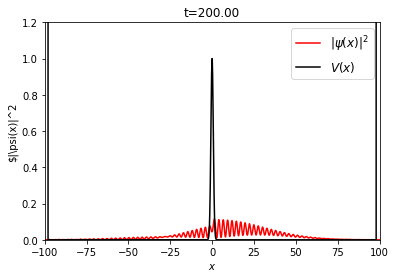

In [39]:
#code modified from Jake Vanderplas

import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation
from scipy.fftpack import fft,ifft

#from google.colab import drive
#drive.mount('/content/drive')

class Schrodinger:

   def __init__(self, x, psi_x0, V_x, k0 = None, hbar=1, m=1, t0=0.0):
   #x = xaxis array of length N giving position
   #V_x = yaxis array of length N giving potential
   #psi_x0 = array of length N giving intial wave function at t0
   #k0 gives the minimumum value of the momentum (there are some constraints on this due to the FFT: k0<k<2pi/dx where dx = x[1]-x[0])
   #default hbar = 1 and mass = 1 and initial time = 0
     self.x, psi_x0, self.V_x = map(np.asarray, (x, psi_x0, V_x))
     N = self.x.size
     assert self.x.shape == (N,)
     assert psi_x0.shape == (N,)
     assert self.V_x.shape == (N,)

     self.hbar = hbar
     self.m = m
     self.t = t0
     self.dt_ = None
     self.N = len(x)
     self.dx = self.x[1] - self.x[0] #setting the pos steps (similar to doing dx = b-a/N as coordinates are evenly spaced)
     self.dk = 2 * np.pi / (self.N * self.dx) #dk = 2pi/Ndx (do this so FFT looks like continuous fourier transform)
     #dk = 2pi/b-a

     if k0 == None:
       self.k0 = -0.5 * self.N * self.dk
     else:
       self.k0 = k0
     self.k = self.k0 + self.dk * np.arange(self.N) # k = k0 + dk
     self.psi_x = psi_x0

   #because we are using the dicrete FFT and iFFT, we have to change psi(x,t) to dx/2pi * psi(x,t) e^(-i k_0 x):
   def _set_psi_x(self, psi_x):
   #gives the discrete vesion of psi needed for the FFT
     self.psi_discrete_x = (psi_x * np.exp(-1j * self.k[0] * self.x) * self.dx / np.sqrt(2 * np.pi))

   def _get_psi_x(self):
   #this just brings it back to the original version of psi(x)
     return (self.psi_discrete_x * np.exp(1j * self.k[0] * self.x) * np.sqrt(2 * np.pi) / self.dx)

   def _get_dt(self):
     return self.dt_

   def _set_dt(self, dt):
     if dt != self.dt_:
       self.dt_ = dt
       self.x_evolve_half = np.exp(-0.5 * 1j * self.V_x / self.hbar * dt ) 
       self.k_evolve = np.exp(-0.5 * 1j * self.hbar / self.m * (self.k * self.k) * dt)
   #explain this bit - basically the functions to do half steps in position and full steps in momentum

   psi_x = property(_get_psi_x, _set_psi_x)
   dt = property(_get_dt, _set_dt)
   #from what I understand, property assigns getter and setter functions to a variable.
   #dont fully understand getter and setter functions but theyre important.

   def time_step(self, dt, Nsteps = 1):
     self.dt = dt

     #then we do the split step fourier method (strang splitting):
     for i in range(Nsteps):
       #half step in position:
       self.psi_discrete_x *= self.x_evolve_half
       #FFT
       self.psi_discrete_k = fft(self.psi_discrete_x)
       #full step in momentum
       self.psi_discrete_k *= self.k_evolve
       #iFFT
       self.psi_discrete_x = ifft(self.psi_discrete_k)
       #half step in position
       self.psi_discrete_x *= self.x_evolve_half

     self.t += dt * Nsteps
     #t = t + Nsteps*dt
       

def gauss_x(x, a, x0, k0):
#wave with width a, centred at x0 with momentum k0
  return ((a * np.sqrt(np.pi)) ** (-0.5) * np.exp(-0.5 * ((x - x0) * 1. / a) ** 2 + 1j * x * k0))


#variables we can change:

dt = 0.01
N_steps = 50
t_max = 200
#can change tmax to run for longer / shorter times
frames = int(t_max / float(N_steps * dt))

#specify constants
hbar = 1.0  
m = 1.0      

#specify range in x coordinate
N = 2 ** 11
dx = 0.1
x = dx * (np.arange(N) - 0.5 * N)

#this is the potential barrier
V0 = 1.0
L = hbar / np.sqrt(2 * m * V0)
x0 = -60 * L
V_x = np.e**((-x**2)/1) 
#+ np.e**((-(x+75)**2)/1) + np.e**((-(x-75)**2)/1)
#potential 'walls' at either end
V_x[x < -98] = 1E6 
V_x[x > 98] = 1E6


#specify initial momentum and quantities derived from it
p0 = np.sqrt(2 * m * 0.8 * V0)
dp2 = p0 * p0 * 1./80
d = hbar / np.sqrt(2 * dp2)

k0 = p0 / hbar
v0 = p0 / m
psi_x0 = gauss_x(x, d, x0, k0)

S = Schrodinger(x=x, psi_x0=psi_x0, V_x=V_x, hbar=hbar, m=m, k0=-28) 

fig = plt.figure()

xlim = (-100, 100)
ymin = 0
ymax = V0
#was 1.5*V0
ax = fig.add_subplot(111, xlim=xlim, ylim=(ymin * (ymax - ymin), ymax + 0.2 * (ymax - ymin)))
psi_x_line, = ax.plot([], [], c='r', label=r'$|\psi(x)|^2$')
V_x_line, = ax.plot([], [], c='k', label=r'$V(x)$')

title = ax.set_title('')
ax.legend(prop = dict(size=12))
ax.set_xlabel('$x$')
ax.set_ylabel(r'$|\psi(x)|^2')

def init():
  psi_x_line.set_data([], [])
  V_x_line.set_data([], [])
  return (psi_x_line, V_x_line)

def animate(i):
    S.time_step(dt, N_steps)
    psi_x_line.set_data(S.x, 4 * abs(S.psi_x)**2)
    V_x_line.set_data(S.x, S.V_x)
    title.set_text('t=%.2f' %S.t)
    return (psi_x_line, V_x_line)

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=frames, interval=30, blit=True)

anim.save('/content/drive/MyDrive/Summer_Project/wave_experiment.mp4', fps=15, extra_args=['-vcodec', 'libx264'])